In [11]:
from os import listdir
from os.path import isfile, join
from PIL import Image

import random
import math
import time
import numpy as np
import cv2
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import torch.nn as nn
import torch.nn.functional as F

In [12]:
widthSteering = heightSteering = 140

widthRoad = 600
heightRoad = 200

modelsPath = 'Models'
modelName = 'bestModel.torch'
pathToModel = f'{modelsPath}/{modelName}'

framesPath = 'Frames'
labeledFrames = 'LabeledFrames'
wheelFrames = 'WheelFrames'

#road crop area
x1R = 400
x2R = 600
y1R = 630
y2R = 1280

#road image size
widthRoad  = y2R - y1R
heightRoad = x2R - x1R

#wheel crop area
x1W = 812
x2W = 932
y1W = 913
y2W = 1033

#wheel image size
widthWheel  = y2W - y1W
heightWheel = x2W-x1W


In [13]:
exist = os.path.exists(modelsPath)
if exist:
    print('Models Path Directoty Exists')
else:
    print('Directory Does not Exists')

exist = os.path.exists(framesPath)
if exist:
    print("Frames Directoty Exists")
else:
    print("Frames Directory Does Not Exists")


exist = os.path.exists(labeledFrames)
if not exist:
    os.makedirs(labeledFrames)
    print("Labled Frames Directoty Created")
else:
    print('Labled Frames Directory Exists')
    #Uncomment these two lines if you want to delete the frames folder before adding more frames
    shutil.rmtree(labeledFrames)
    os.makedirs(labeledFrames)

exist = os.path.exists(wheelFrames)
if not exist:
    os.makedirs(wheelFrames)
    print("Wheel Frames Directoty Created")
else:
    print('Wheel Frames Directory Exists')
    #Uncomment these two lines if you want to delete the frames folder before adding more frames
    shutil.rmtree(labeledFrames)
    os.makedirs(labeledFrames)

Models Path Directoty Exists
Frames Directoty Exists
Labled Frames Directoty Created
Wheel Frames Directoty Created


In [14]:
startingFrames = [f for f in listdir(framesPath) if isfile(join(framesPath, f))]

In [15]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(512, 128)
        
        self.branch_a1 = nn.Linear(128, 32)
        self.branch_a2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc(x))

        a = F.leaky_relu(self.branch_a1(x))
        
        out1 = self.branch_a2(a)
        
        return out1

In [16]:
#load net
#To Load Pretrained Weights:   weights='ResNet18_Weights.DEFAULT'
resnet18 = torchvision.models.resnet18()
resnet18.fc = nn.Identity()
net_add=net()
model = nn.Sequential(resnet18, net_add)

# Set device GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

# load model to GPU
model = model.to(device)

model.load_state_dict(torch.load(pathToModel))

model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [17]:
def run():
    i = 0
    for file in startingFrames:
        i=i+1
        if i%1000 == 0:
            print(f'Frame No: {i}')
        #dont want the '.jpg' element of the file name in the file name
        noExtension = file[:-4]

        filePath = f'{framesPath}/{file}'

        #load image
        wholeFrame = cv2.imread(filePath)

        #crop to steering wheel logo and transform image to black and white but in RGB color space
        crop = wholeFrame[x1W:x2W, y1W:y2W]

        grayImage = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        (thresh, contrastImg) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)
        backtorgb = cv2.cvtColor(contrastImg,cv2.COLOR_GRAY2RGB)

        

        transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((heightWheel,widthWheel)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
        wheel=transformImg(np.array(backtorgb))

        wheel = wheel.to(device).unsqueeze(0)

        with torch.no_grad():
            prediction = model(wheel)  # Run net

        detectedAngle = prediction.data.cpu().numpy()[0][0]

        realAngle = (180*detectedAngle)-90

        cv2.imwrite(f'{wheelFrames}/wheelCrop_angleNorm_{detectedAngle}_angleReal_{realAngle}.jpg',backtorgb)

        crop = wholeFrame[x1R:x2R, y1R:y2R]

        cv2.imwrite(f'{labeledFrames}/{detectedAngle}_degrees_roadcrop_{noExtension}.jpg',crop)



In [18]:
run()

In [19]:
path = 'WheelFrames'
files = [f for f in listdir(path) if isfile(join(path, f))]

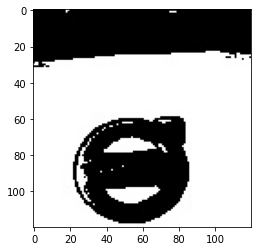

4.107513427734375 Degrees
0.5228195190429688 Normalised


In [20]:
n = random.randrange(0,len(files))

#Import image
cv2img = cv2.imread(f'{path}/{files[n]}')

#Show the image with matplotlib
plt.imshow(cv2img)
plt.show()

split = files[n].split('_')

print(f'{split[4][:-4]} Degrees')
print(f'{split[2]} Normalised')